In [708]:
from numpy import *
from numpy.linalg import *

from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Chariot Model
==============

We consider a mobile robot of "chariot" type, evolving in the plane.

  - From above, its frame appears to be a disk of diameter $D$. 
  
  - It has two fixed wheels (their orientation with respect to the frame does not change; there is no need for a steering wheel!). They are parallel and located at opposite ends of the frame (hence separated by a distance of $D$) ; these wheels have the common radius $R$.

  - The robot is symmetric with respect to the axis that joins the two wheels. For convenience, a green sticker is attached at the boundary of the frame on one side of this axis, on the robot axis of symmetry ; this side will is called the "front" of the robot, the point itself is called the "nose" of the robot. When we talk about the "left wheel" or the "right wheel", we assume that we are looking towards the front of the robot.

We will denote 

  - $(x, y)$ the coordinates of the wheel axis in the orthonormal and direct frame $(0, e_x, e_y)$ of the plane.
  
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the robot faces the right ($e_x$) and $\theta = \pi/2$ when he faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the robot moves forward.

### Parameter Definition


From now on, we assume that the frame diameter is $D = 1 \mbox{ m}$ and the wheel radius is $R = 10 \mbox{ cm}$.

🧩 Define the corresponding Python variables `D` and `R` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [709]:
D = 1
R = 10 / 100

### Graphical Representation

🧩 Implement a function `draw_robot` with arguments `x`, `y` and `theta` that draws the robot in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Represent the robot frame as a circle, the wheels as lines and the nose as an orange point.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [710]:
def draw_robot(x, y, theta):
    frame_radius = 0.5 * D
    translation = array([x, y])
    rotation = array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

    # Frame
    angle = linspace(0, 2*pi, 1000)
    plot(x + frame_radius * cos(angle), y + frame_radius * sin(angle), color="black")
    
    # Wheels
    wheel_left_xy_start = rotation @ [-R, frame_radius] + translation 
    wheel_left_xy_end = rotation @ [R, frame_radius] + translation
    wheel_right_xy_start = rotation @ [-R, -frame_radius] + translation
    wheel_right_xy_end = rotation @ [R, -frame_radius] + translation
    plot([wheel_left_xy_start[0], wheel_left_xy_end[0]], [wheel_left_xy_start[1], wheel_left_xy_end[1]], color="black",linewidth=5)
    plot([wheel_right_xy_start[0], wheel_right_xy_end[0]], [wheel_right_xy_start[1], wheel_right_xy_end[1]], color="black", linewidth=5)
    
    # Nose
    xn, yn = rotation @ [frame_radius, 0] + translation
    plot([xn], [yn], marker=".", color="orange", markersize=15)
    

🧩 Represent the robot in when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, -\pi), (-4, 4, -\pi), (-8, 4, -\pi)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [711]:
def draw_arena(xmin=-12, xmax=12, ymin=-9, ymax=9):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)
    plot([xmin, xmax], [0, 0], linestyle="-", color="grey")
    plot([0, 0], [ymin, ymax], linestyle="-", color="grey")

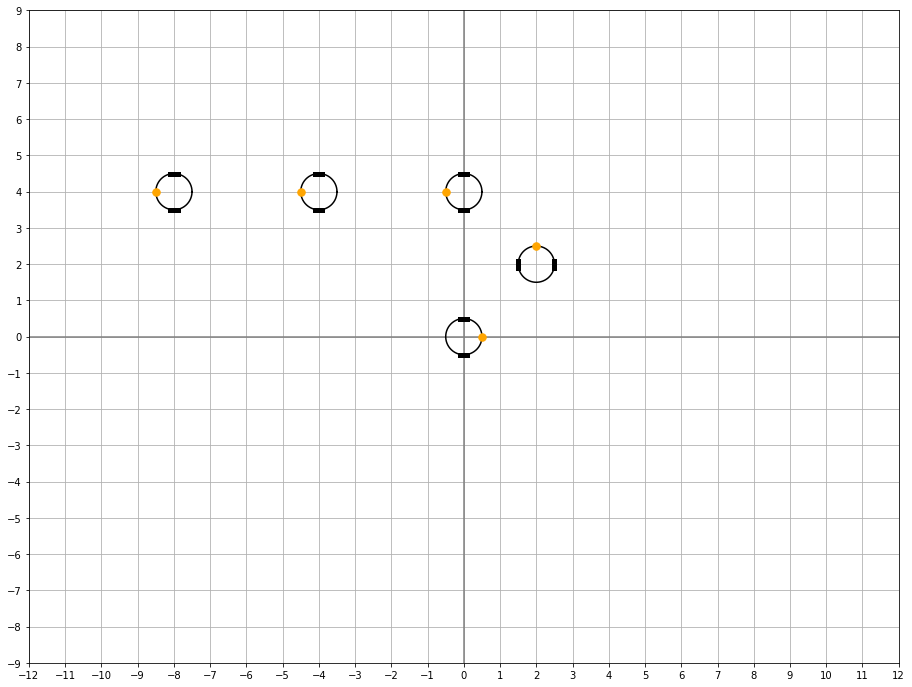

In [712]:
draw_arena()
draw_robot(0, 0, 0)
draw_robot(2, 2, pi/2)
draw_robot(0, 4, -pi)
draw_robot(-4, 4, -pi)
draw_robot(-8, 4, -pi)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the robot).
We also assume that the chariot wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

$$
\begin{array}{rcl}
\dot{x} &=& R  \frac{\omega_l + \omega_r}{2} \cos \theta \\
\dot{y} &=& R  \frac{\omega_l + \omega_r}{2} \sin \theta \\
\dot{\theta} &=& R  \frac{\omega_r - \omega_l}{D} \\
\end{array}
$$

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

The vector field is continuously differentiable as a composition of continuously differentiable functions, thus the IVP is well-posed.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

When the inputs are constant, it's pretty easy to prove that the derivatives of $x$, $y$ and $\theta$ with respect to $t$ are uniformly bounded ; thus $x$, $y$ and $\theta$ are bounded on any bounded time interval and therefore no finite-time blowup may happen: the maximal solution is global.

The situation is different with state-dependent inputs; for example with $\omega_r = - \omega_l = 0.5 D/R * \theta^2$, we end up with $\dot{\theta} = \theta(t)^2$ which has a finite-time blowup for some initial values of $\theta$. Thus, the maximal solution may not be global.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [713]:
def omega(t, xytheta):
    omega_l = 7.5 * pi
    omega_r = 12.5 * pi
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$, $(x,y,\theta)$ (and  -- implicitly -- the inputs $\omega$ computed by the function `omega`).

In [714]:
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = R * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = R * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = R * (omega_r - omega_l) / D
    return array([dx, dy, dtheta])

### Simulation Setup

🧩 Simulate the robot dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = 7.5 \pi$ and $\omega_r = 12.5 \pi$.
(Compute the dense outputs.)
   

In [715]:
r = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

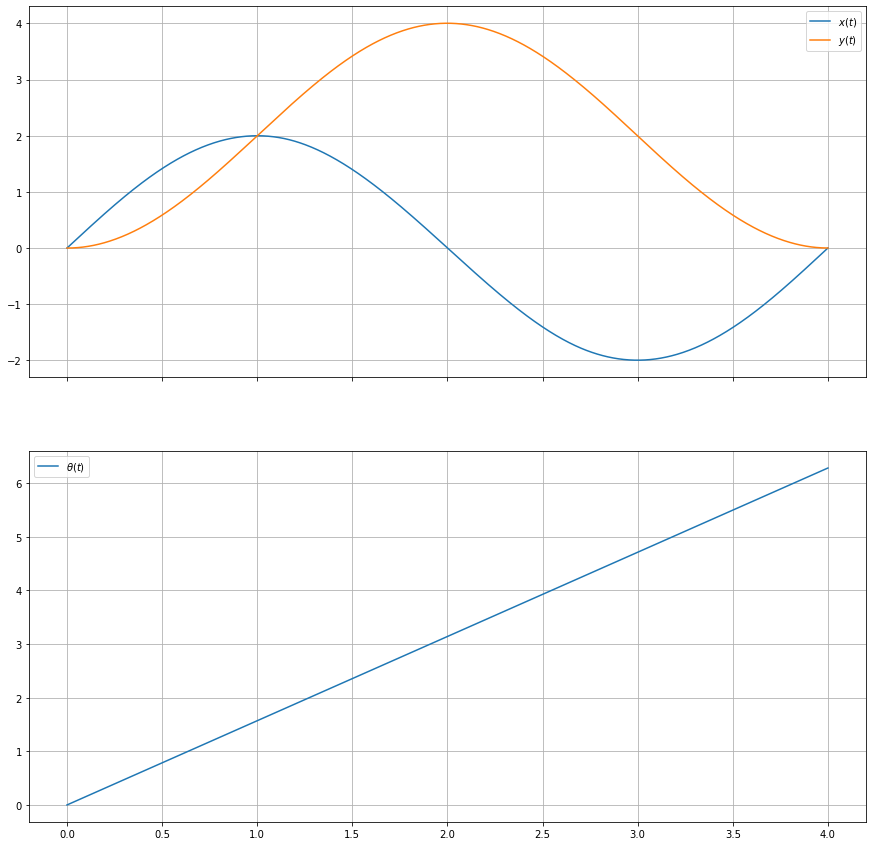

In [716]:
t = linspace(0.0, 4.0, 1000)
x, y, theta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$")
ax2.legend()
pass

🧩 Use the simulation results to display the robot location every 0.5 second.

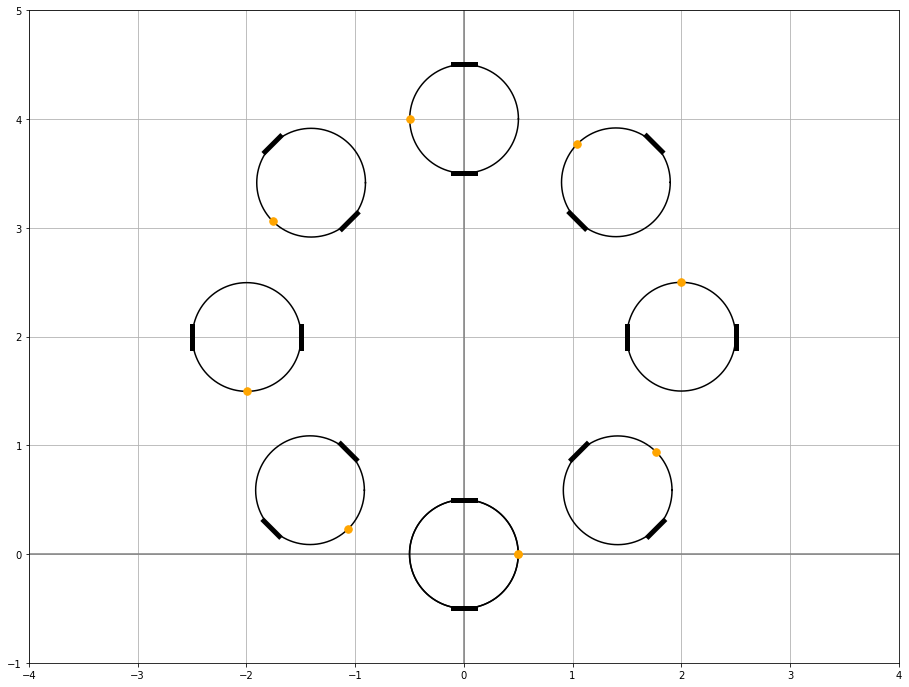

In [717]:
t = linspace(0.0, 4.0, 4*2+1)
sol_t = r["sol"](t)
draw_arena(-4, 4, -1, 5)
for x, y, theta in sol_t.T:
    draw_robot(x, y, theta)

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

$\theta(t) = 2 \pi / 4.0$, $x(t) = 2\sin(2\pi t / 4)$ and $y(t) = -2 \cos(2\pi t / 4)+2$.

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

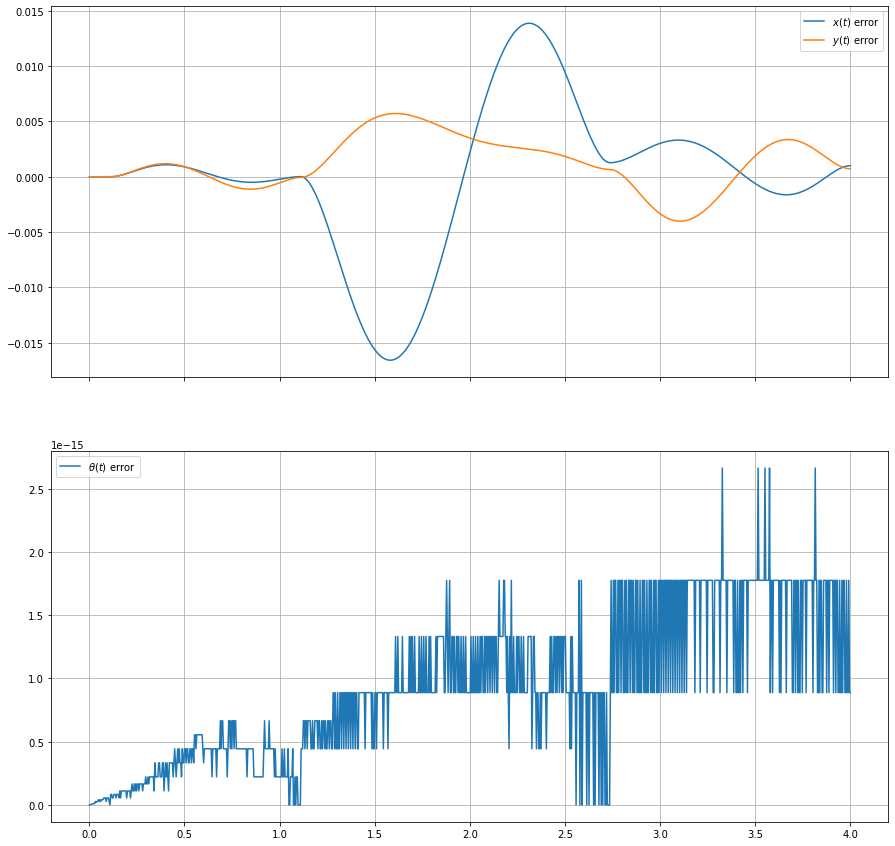

In [718]:
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
pass

🧩 If needed, adjust the simulation parameters until this error is uniformly less than $1e-5$.

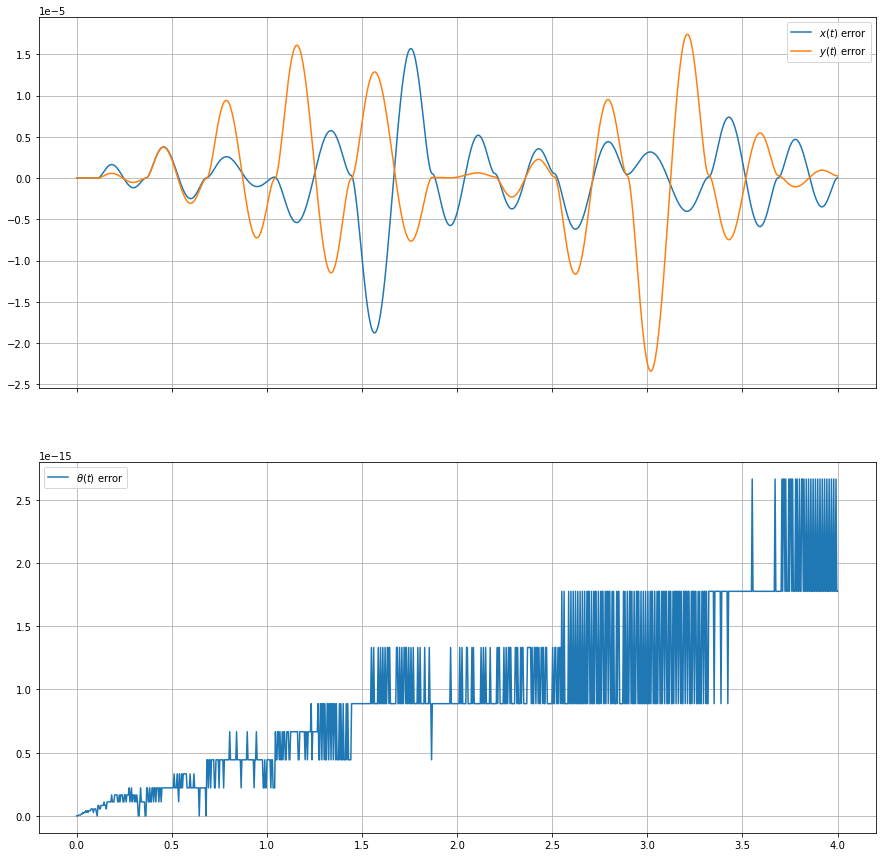

In [719]:
r = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], rtol=1e-6, atol=1e-12, dense_output=True)
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
pass

Step2: implementing control
=====

Time dependent inputs
-----

We are going to simulate the case of the chariot controlled by time-dependent angular velocities $\omega_l$ and $\omega_r$. 

We want a simulation of 10s with the following inputs:
$$
    \omega_l(t) = \left\{
       \begin{array}{ll}
           2\pi & \mbox{when t $\leq$ 5s} \\
           \pi & \mbox{otherwise}
       \end{array}
    \right.
$$
and
$$
    \omega_r(t) = \left\{
       \begin{array}{ll}
           2\pi & \mbox{when t $\geq$ 5s} \\
           \pi & \mbox{otherwise}
       \end{array}
    \right.
$$

🧩 Provide the new definition of `omega`

In [720]:
def omega(t, xytheta):
    if t <= 5:
        omega_l = 2*D*pi
        omega_r = D*pi
    else:
        omega_l = D*pi 
        omega_r = 2*D*pi
    return array([omega_l, omega_r])

🧩 Make a simulation of 10s of the robot with the previous input **without specifying** any parameter to improve the accuracy (`rtol`, `atol` and `max_step` at their default value) and by using the `dense_output` option to evaluate the solution at timesteps that will be defined later.

🗝️ **Hint.** This is not necessary to define again the function `fun`. If the previous cell has been correctly validated, `fun` will use the new definition of `omega`. 


In [721]:
tf = 10
r = solve_ivp(fun=fun,y0=[0,0,0],t_span=[0,tf],dense_output=True)

🧩 Use the simulation results to display the robot location every 1.5 seconds.

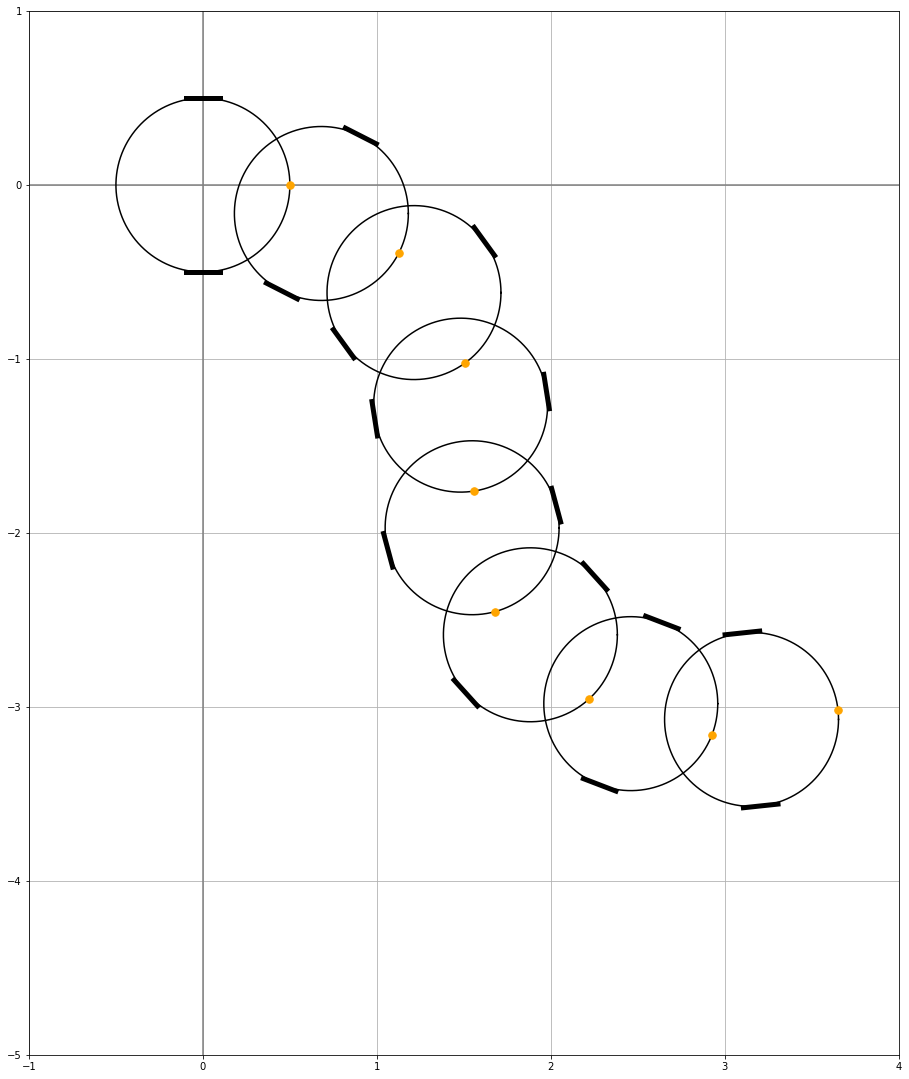

In [722]:
step = 1.5
t = arange(0,tf+step,step)
sol_t = r["sol"](t)
draw_arena(-1, 4, -5, 1)
for x, y, theta in sol_t.T:
    draw_robot(x, y, theta)

## Analysis of the system at rest

### Equilibrium

🧩 Show that for a suitable (constant) choice $\omega_e \in \mathbb{R}^2$ of the vector input $\omega$, the state $X_e = (x_e, y_e, \theta_e) = (0,0,0)$ is an equilibrium of the mobile robot.



**Answer:**

If $\omega_e=(0,0)$, $f(X_e)=0$ ($X_e=(0,0,0)$), and so $X_e$ is an equilibrium of the mobile robot.

🧩 Show that for any other $\omega_e$, the system has no equilibrium.

**Answer:**

If $\omega_l\neq 0$ or $\omega_l\neq 0$, two cases:

  1. $\omega_l\neq-\omega_r$ which is different from zero, thus $\dot{x}=\dot{y}=0$ implies $\cos\theta=\sin\theta=0$ which is impossible.
  2. $\omega_l=-\omega_r$ which is different from zero, thus $\dot{\theta} = 2\omega_r\frac RD \neq 0$

So, there is no equilibrium if $\omega \neq \omega_e$

🧩 Conversely, if $\omega = \omega_e$, what are the other equilibria of the system?

**Answer:**

If $\omega=\omega_e$, then $\forall X\in\mathbb{R}^3,f(X) = 0$. Every position is an equilibrium (actually, the system is at rest)

### Linearized System


Let $\omega = \omega_e$ and $X_e = (0,0,0)$.

Introduce the error variables $\Delta X = (\Delta x, \Delta y, \Delta \theta) = X - X_e$.

🧩 Compute the corresponding linearized dynamics and put it in standard form: compute the matrices $A$ and $B$ (remember that $\omega = (\omega_l,\omega_r)$.

**Answer:**

$$
A= \begin{bmatrix} 0 & 0 &0 \\ 0 & 0 &0 \\ 0 & 0 & 0\end{bmatrix}
$$
and
$$
B= \begin{bmatrix} \frac R2 & \frac R2  \\ 0 & 0 \\ -\frac RD & \frac RD \end{bmatrix}
$$

### Stability of the linearized system

🧩 Is the linearized system asymptotically stable around $(0,0,0)$ when $\Delta \omega = (0,0)$ ?

**Answer:**

No, with the chosen $\Delta \omega$, we have $\dot X = A.X$ and $A$ has three null eigen values. To have a positive answer, we expected that each eigen value has a strictly negative real part

🧩 Is the original system asymptotically stable ? Or even (locally) attractive ? 

**Answer:**

With $\omega = \omega_e$, the system cannot "move". If $X(t_0) = X_0$, then $\forall t>0, X(t) =X_0$. Thus, if $X_0\neq (0,0,0)$, $X(t)$ cannot converge to the origin: the original system is not (even locally) attractive.

As a consequence, it is not AS.

### Controllability of the linearized system

In this section, we consider only the linearized system defined by the matrices $A$ and $B$ computed previously:
$$
  \dot{\Delta X} = A.\Delta X + B\Delta u
$$

🧩 Is there an admissible trajectory that start with the state $X_0=(-2,0,0)$ and ends at origin after some time?  

**Answer:**

Yes, with $\omega \propto (1,1)$, the robot will move in straight line on the (Ox) axis and will reach the origin after some time depending on the speed.

🧩 Is there an admissible trajectory that start with the state $X_0=(0,2,0)$ and ends at origin after some time?  

**Answer:**

No. According to $A$ and $B$, we have $\dot{\Delta y}=0$ and so, the error on $y$ cannot be changed by $u$.

🧩 Is the linearized system controllable?

**Answer:** 

No, 2 possible proof:

1. Kalman criteria: the controllability matrix has the same rank of $B$ (since $A =0$) which is 2.
2. We found that some points are not reachable with specific initial condition

## Control on a straight line

### Admissible trajectories

Let $x_R(t) = v t$ and $y_R(t) = 0$ where $v \in \mathbb{R}$ and $v \neq 0$. 

🧩 Determine the set of trajectories $X_R(t) = (x_R(t), y_R(t), \theta_R(t))$ which are admissible and compute the corresponding reference control $\omega_{R}(t)$.

**Answer:**

$y_R(t) = 0 \Rightarrow$ $\sin\theta_R = 0$ or $(\omega_l+\omega_r)/2 = 0$. The second case leads to $\dot{x}$=0 which is in contradiction with $\dot x_R = v$.
Thus, $\theta_R(t) = k\pi$. By continuity ($\theta$ cannot jump from $k\pi$ to $k'\pi$), this defines several sets of solutions in which $\theta_R(t)$ is constant and equal to $k\pi$. This leads to $\dot\theta=0$ and so $\omega_l(t)=\omega_r(t)=\omega(t)$

Finally, $\dot x = R\omega(t)\cos k\pi$.

We have actually 2 true sets of solutions (all the other sets will lead to the same control according to the parity of  :

1. $X_R(t) = (vt ,0, 0)$ with a reference control $\omega_R(t)=(v/R,v/R)$
1. $X_R(t) = (vt ,0, \pi)$ with a reference control $\omega_R(t)=(-v/R,-v/R)$





### Linearized system

Let $\Delta X(t) = X(t) - X_R(t)$ and $\Delta \omega(t) = \omega(t) - \omega_R(t)$.

🧩 Compute the linearized dynamics of the system for the class of trajectory "moving forward".

**Answer:**

$$
  A = \begin{bmatrix}
      0 & 0 & 0 \\
      0 & 0 & v \\
      0 & 0 & 0
  \end{bmatrix}
$$

and 

$$
   B=\begin{bmatrix}
    \frac R2 & \frac R2  \\ 0 & 0 \\ -\frac RD & \frac RD
  \end{bmatrix}
$$

🧩 Is the system asymptotically stable, with $\Delta\omega(t)=0$?

**Answer:**

[NO](https://www.youtube.com/watch?v=caXgpo5Ezo4) because $A$ has 3 null eigen values

🧩 Is the system attractive, with $\Delta\omega(t)=0$?

**Answer:**

[NO](https://www.youtube.com/watch?v=caXgpo5Ezo4). Two possible justifications:
1. With an argument of the course: for linear system, locally attractive is equivalent to GAS. The system is not GAS (pprevious question).
2. By looking the system: e.g. the error $\Delta y$ remains constant without any input correction.

🧩 Show that the linearized system is controllable.

**Answer:**

We just study the rank of $C' = [B, AB]$ since $A^i=0$ for $i\geq2$

$$C'=
\begin{bmatrix}
    \frac R2 & \frac R2 & 0 & 0 \\
    0 & 0 & -v \frac RD & v \frac RD \\
    -\frac R2 & \frac R2 & 0 & 0
\end{bmatrix}
$$

The submatrix defined by keeping the 3 first columns if full rank. So, the controllability matrix is also full rank and the system is controllable.

### Linearized system implementation

In the sequel, we will use $v=10km/h$

🧩 Implement and print the matrices $A$ and $B$

In [723]:
v = 10/3.6
A = array([[0,0,0],[0,0,v],[0,0,0]])
B = array([[R/2,R/2],[0,0],[-R/D,R/D]])
print(A)
print(B)

[[0.         0.         0.        ]
 [0.         0.         2.77777778]
 [0.         0.         0.        ]]
[[ 0.05  0.05]
 [ 0.    0.  ]
 [-0.1   0.1 ]]


The linear model as to be fed with some $\Delta\omega$ input. Like for the non linear system, we define a function $\Delta\omega(t,\Delta_X)$ that computes the input of the linearized system. For example, if we do not want any correction to the reference input, we will have:

In [724]:
def deltaOmega(t,deltaX):
    return array([0,0,0])

🧩 Implement a function `lin_fun(t, deltaX)` that computes $\dot{\Delta X}$ given the time $t$, $\Delta X$ (and  -- implicitly -- the inputs $\Delta\omega$ computed by the function `deltaOmega`).

In [725]:
def lin_fun(t,deltaX):
    return A@deltaX+B@deltaOmega(t,deltaX)

### Controller Design on the linearized system

🧩 Implement a process that computes a gain matrix $K$ that places the poles of the linearized system at some arbitrary location. For this question, we will chose 3 real poles with an absolute value close to 0.3.

Then, print the effective poles of the system: 

$$
\dot{\Delta X}= A.\Delta X + B\Delta\omega
$$
with
$$
\Delta\omega = -K.\Delta X
$$

In [726]:
poles = [-.35,-.31,-0.32] # Strictly negative real part
K = place_poles(A,B,poles).gain_matrix
print(K)
e,_ = eig(A-B@K)
print(e)

[[ 3.1999963  -0.18803069 -3.2397191 ]
 [ 3.20000092  0.20256949  3.36028229]]
[-0.32 -0.35 -0.31]


🧩 Simulate the linearized system during 10s, with an initial condition $\Delta X(0) = (0,2,0)$.

In [727]:
def deltaOmega(t,deltaX):
    return -K@deltaX

tf = 10
r = solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)

🧩 Plot the values of $\Delta x(t)$, $\Delta y(t)$ and $\Delta\theta(t)$ (**plot $\Delta\theta(t)$ in degrees**)

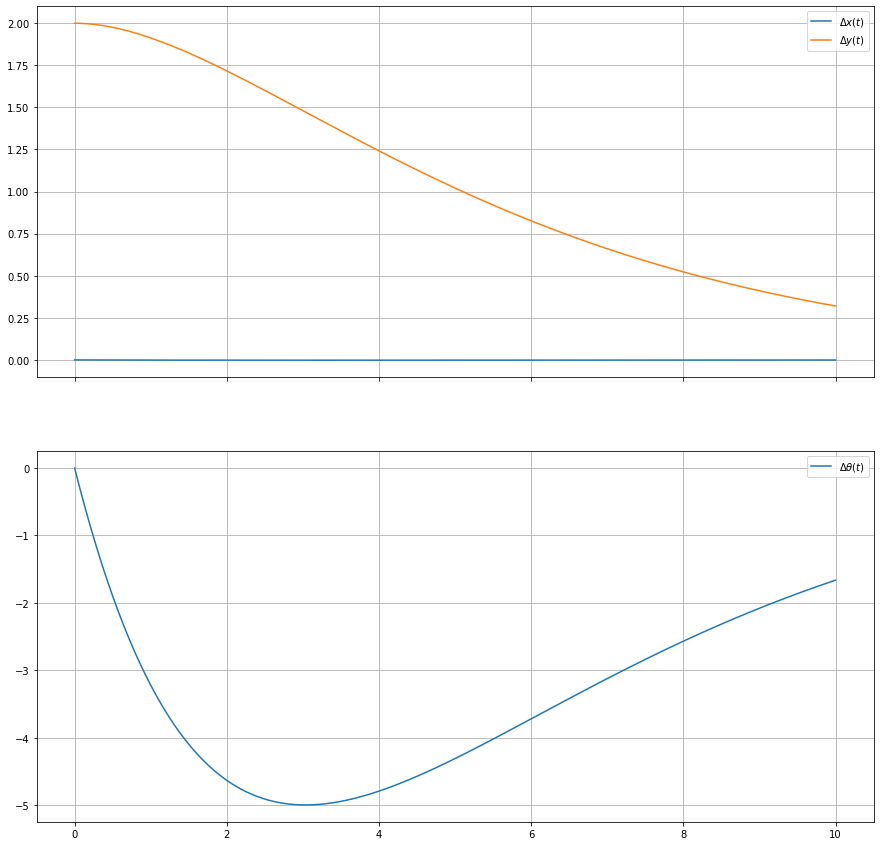

In [728]:
t = linspace(0.0,tf, 1000)
dx, dy, dtheta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$")
ax2.legend()
pass

🧩 Why is it important to check that $\Delta\theta(t)$ stays small ?

**Answer:**

The heading angle is the source of non linearity. To preserve the quality of the linearization, it is important that the error is small.

🧩 Compute the corresponding values of $\Delta\omega_l,\Delta\omega_r$ and store them in the Python variables `dOmega_l`, `dOmega_r`

In [729]:
dX = r["sol"](t)
dOmega = -K@dX
dOmega_l = dOmega[0,:]
dOmega_r = dOmega[1,:]

🧩 Compute $\omega_l,\omega_r$ and plot the translation speed of each wheels in km/h

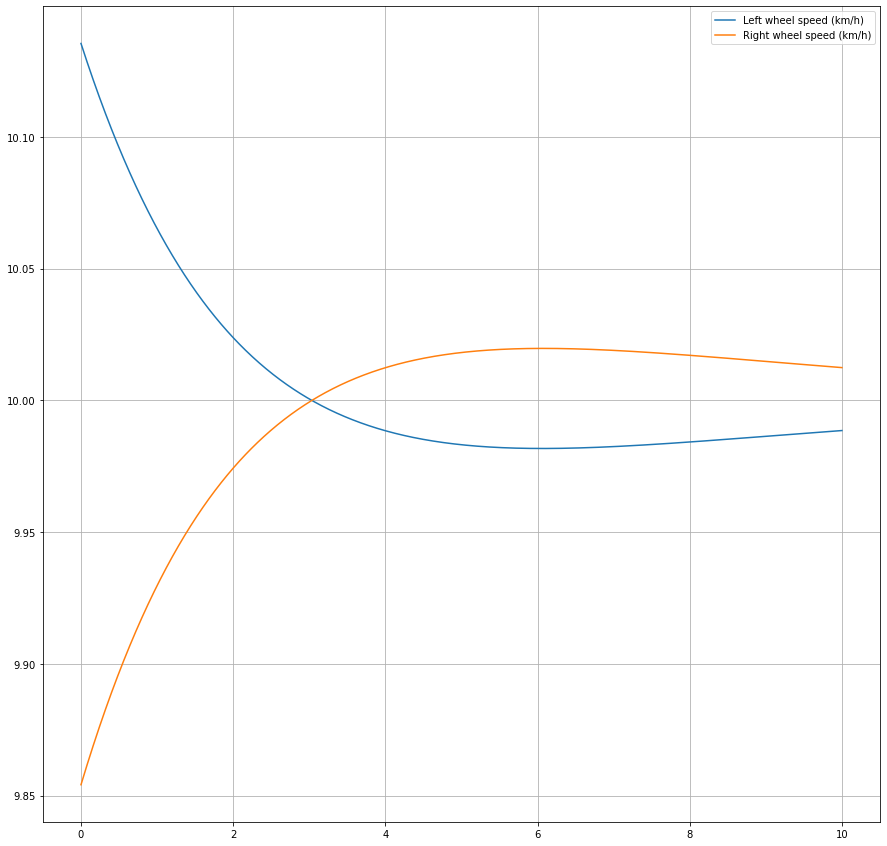

In [730]:
omega_l = dOmega_l +v/R
omega_r = dOmega_r +v/R

fig=figure(figsize=(15, 15))
plot(t,omega_l*R*3.6, label=r"Left wheel speed (km/h)")
plot(t,omega_r*R*3.6, label=r"Right wheel speed (km/h)")
grid()
legend()
pass

🧩 Are the control values consistent with what the robot should do to cancel the error?

**Answer:**

If there is not any error, the target speed of both wheels is 10km/h. This is the value to which $\omega_l$ and $\omega_r$ look to converge.

At the beginning, the robot is a little bit too high ($y>0$), so it has to turn right. To do this, the left wheel has to be faster than the right one. This is effectively what we observes, and both values are arount 10km/h.



###  Controller Tuning



Tune the poles so that the actual location $(x, y)$ is within 10 cm of the desired location within 5 sec (**keep continue to simulate during 10sec**) and the linear velocity of each wheel never exceeds $15$ km/h. Plot the values of $\Delta x$ (in m), $\Delta y$ (in m), $\Delta \theta$ (in degrees), and the speed of each wheel (in km/h)

🗝️ **Hint.** To answer this question, you can copy/paste the code of the previous questions to generate the appropriate plots.


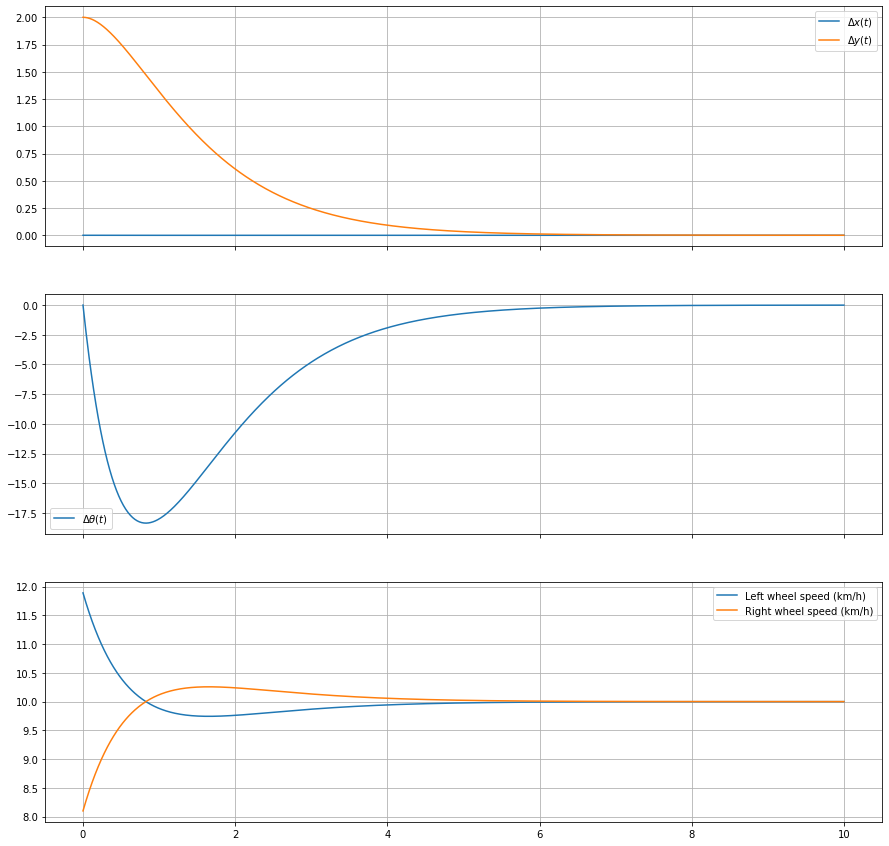

In [731]:
# Definition of K
poles = [-1.2,-1.21,-1.22] # Strictly negative real part
K = place_poles(A,B,poles).gain_matrix


# Solver
tf = 10
r = solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)

#plots
t = linspace(0.0,tf, 1000)
dx, dy, dtheta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$")
ax2.legend()

dX = r["sol"](t)
dOmega = -K@dX
dOmega_l = dOmega[0,:]
dOmega_r = dOmega[1,:]
omega_l = dOmega_l +v/R
omega_r = dOmega_r +v/R

ax3.plot(t,omega_l*R*3.6, label=r"Left wheel speed (km/h)")
ax3.plot(t,omega_r*R*3.6, label=r"Right wheel speed (km/h)")
ax3.legend()
ax3.grid()


Step3: Optimal control, Global Control and General Trajectories
=====


###  Optimal control

In this part we aim to design a stabilizing controller using an optimal control methodology. 

We still want to follow the reference trajectoy $x_R(t) = v t$ and $y_R(t) = 0$ where $v \in \mathbb{R}$ and $v \neq 0$ and will work with the linearized system 
$$
\dot{\Delta X}= A.\Delta X + B\Delta\omega
$$

We want to find the control input $\Delta\omega$ that minimizes the quantity $J$ defined by
$$
J=\int_0^T q_1(\Delta x(t))^2 + q_2(\Delta y(t))^2 + q_3(\Delta \theta(t))^2+ r_1(\Delta \omega_l(t))^2+ r_2(\Delta \omega_r(t))^2 dt
$$
where the different constant $q_i$ and $r_i$ are strictly positive. We will denote 
$$
Q=\begin{bmatrix}
      q_1 & 0 & 0 \\
      0 & q_2 & 0 \\
      0 & 0 & q_3
  \end{bmatrix}
$$
and
$$
R_0=\begin{bmatrix}
      r_1 & 0 \\
      0 & r_2 \\
  \end{bmatrix}
$$

🧩 Compute a function `Compute_cost` that computes the function J for a given set of matrices $Q$ and $R$, a time horizon $t=[0,T]$, and for the corresponding functions $\Delta X$ and $\Delta \omega$ .
To compute the integral, you can use the function `quad` (https://docs.scipy.org/doc/scipy/tutorial/integrate.html). You may need an intermediate function that returns the quantity
$$
q_1(\Delta x(t))^2 + q_2(\Delta y(t))^2 + q_3(\Delta \theta(t))^2+ r_1(\Delta \omega_l(t))^2+ r_2(\Delta \omega_r(t))^2
$$

In [732]:

def quantity(Q,R,K,t):

    return lambda t: sum(dot(Q,r["sol"](t)**2)) + sum(dot(R,-K@r["sol"](t)**2))

In [733]:
import scipy.integrate as integrate
import scipy.special as special

def Compute_cost(q,t):
    return integrate.quad(q, t[0],t[1])

🧩 Test the function `Compute_cost`  with the controller you designed in the Section 'Controller Tuning' when $q_i=1$ and $r_i=1$ ($T=10$).

In [734]:
#params
Q=np.eye(3)
R_matrix=np.eye(2)
T=10
K = place_poles(A,B,poles).gain_matrix


#testing the function

test =  Compute_cost(quantity(Q,R_matrix,K,t),t)
test[0]

0.039495849407111025

🧩 Multiply by 10 the poles and test the function `Compute_cost` in this new case. Interpretate the results. 

In [735]:
K = place_poles(A,B,list(10*np.array(poles))).gain_matrix

#testing the function

test = integrate.quad(quantity(Q,R_matrix,K,t), 0, 10)
test[0]

7.7265931434221

we can see that the intgral increases with number of poles

🧩 Implement a process that computes a gain matrix $K$ that places the poles of the linearized system such that the quantity $J$ is minimum with "T=$+\infty$" 

Then, for $q_i=1$, $r_i=1$, print the effective poles of the system:
$$
\dot{\Delta X}= A.\Delta X + B\Delta\omega
$$
with
$$
\Delta\omega = -K.\Delta X
$$

In [757]:
from scipy import linalg

Pi = linalg.solve_continuous_are(A, B, Q, R_matrix)
K = inv(R_matrix) @ B.T @ Pi


print(f"The value of K is :\n {K}")



The value of K is :
 [[ 0.70710678 -0.70710678 -4.48796781]
 [ 0.70710678  0.70710678  4.48796781]]


🧩 Plot the values of $\Delta x$ (in m), $\Delta y$ (in m), $\Delta \theta$ (in degrees), and the speed of each wheel (in km/h). Compute the value of the cost for $T=10$. Compare with the control law you obtained by pole placement. Intepretate the results

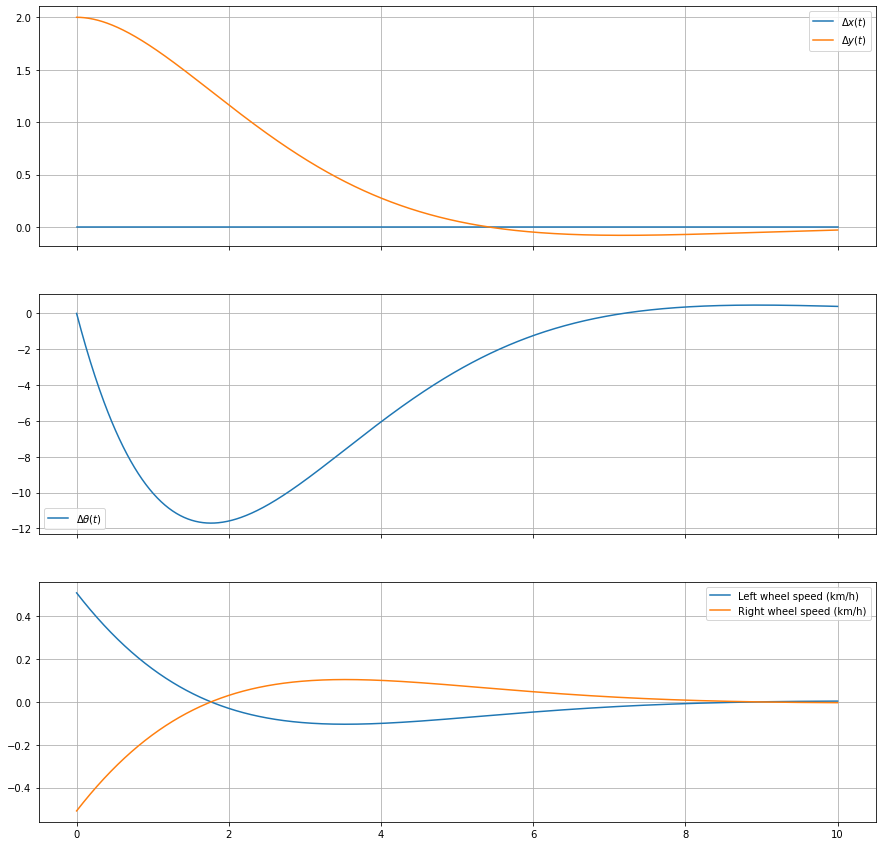

In [737]:
#solution

tf = 10
r = solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)

#plot the graphs
t = linspace(0.0,tf, 1000)
dx, dy, dtheta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2, ax3 = fig.subplots(3, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, dx, label="$\Delta x(t)$")
ax1.plot(t, dy, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, dtheta*180/pi, label=r"$\Delta\theta(t)$")
ax2.legend()

dX = r["sol"](t)
dOmega = -K@dX
dOmega_l = dOmega[0]
dOmega_r = dOmega[1]
omega_l = dOmega_l 
omega_r = dOmega_r 

ax3.plot(t,omega_l*R*3.6, label=r"Left wheel speed (km/h)")
ax3.plot(t,omega_r*R*3.6, label=r"Right wheel speed (km/h)")
ax3.legend()
ax3.grid()


🧩 How would you choose the matrices $Q$ and $R$ to reduce the control effort? To guarantee a fast convergence? What would be the problem of having high values for the matrix $Q$? Validate your results with adequate simulations

**Answer :**

As the graph below indicates, if the values of Q increase then we can guarantee a fast convergence, because with Q=Q*20 we have a convergence at around 3 and with previous value of Q we have a convergence at  around 8

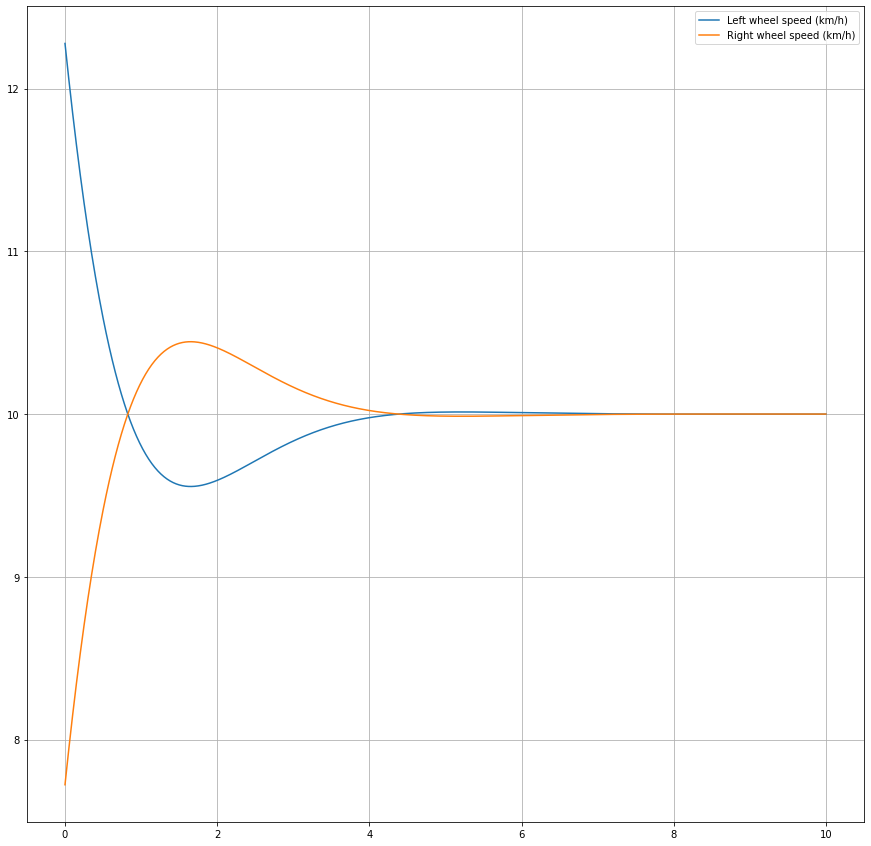

In [738]:
# Chnage Q

Q_large=Q*20


Pi = linalg.solve_continuous_are(A, B, Q_large, R_matrix)
K = inv(R_matrix) @ B.T @ Pi


# Solver
tf = 10
r = solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)

#plots
t = linspace(0.0,tf, 1000)

fig=figure(figsize=(15, 15))
ax1 = fig.subplots( sharex=True)

dX = r["sol"](t)
dOmega = -K@dX
dOmega_l = dOmega[0]
dOmega_r = dOmega[1]
omega_l = dOmega_l +v/R
omega_r = dOmega_r +v/R

ax1.plot(t,omega_l*R*3.6, label=r"Left wheel speed (km/h)")
ax1.plot(t,omega_r*R*3.6, label=r"Right wheel speed (km/h)")
ax1.legend()
ax1.grid()


### Controller validation

The goal of this part is to test the controller on the **true** non linear system.
The idea is the following:
  - We are going to simulate the original `fun` function
  - We need to define a new version of the function `omega` that computes the wheel velocities. Basically, the following steps will be necessary:
    1. Compute $\Delta X(t)$
    1. Compute $\Delta\omega(t)$
    1. Compute $\omega(t)$ thanks to $\Delta\omega(t)$ and $\omega_R(t)$
    
🧩 Implement the new version of `omega`

In [739]:
def omega(t, xytheta):
    deltaX=[xytheta[0]-v*t,xytheta[1],xytheta[2]]
    deltaOmega=-K@deltaX
    return deltaOmega+v/R

🧩 Simulate the true system during 10sec using the pole placement controller

In [740]:
poles =[-1.2,-1.21,-1.22] # Strictly negative real part
K = place_poles(A,B,poles).gain_matrix

# Solver
tf = 10 #for 10 seconds
r = solve_ivp(fun=fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)

🧩 Use the simulation results to display the robot location every 1 second.

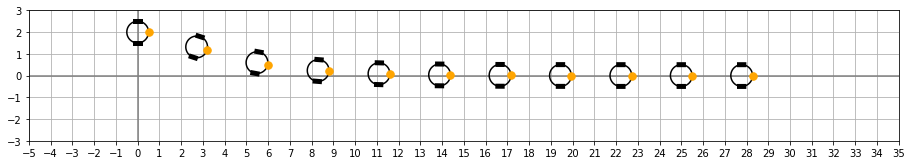

In [741]:
# display the location of the robot every 10 seconds

step = 1
t = arange(0,tf+step,step)
sol_t = r["sol"](t)
draw_arena(-5, 35, -3, 3)
for x, y, theta in sol_t.T:
    draw_robot(x, y, theta)

🧩 Plot the variables $x(t)$, $y(t)$, $\theta(t)$

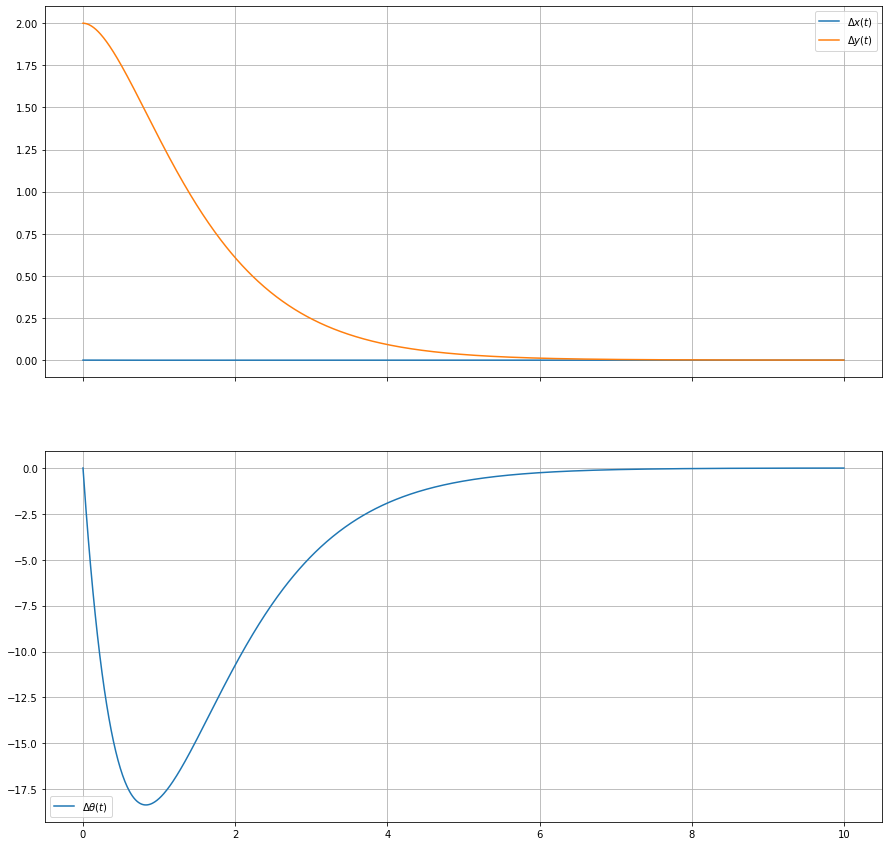

In [742]:
# initiate K with some poles
poles = [-1.2,-1.21,-1.22] # Strictly negative real part

# Solver
tf = 10
r = solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)

#plots
t = linspace(0.0,tf, 1000)
x, y, theta = r["sol"](t)
fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$\Delta x(t)$")
ax1.plot(t, y, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta*180/pi, label=r"$\Delta\theta(t)$")
ax2.legend()


🧩 We now aim to compare the different control strategies. We consider the pole placement strategy and two optimal controllers (one with a large $Q$ and one with a large $R$). Run the simulations with the two optimal controllers.

#### Simulation for larger Q :

 Simulation for larger Q :


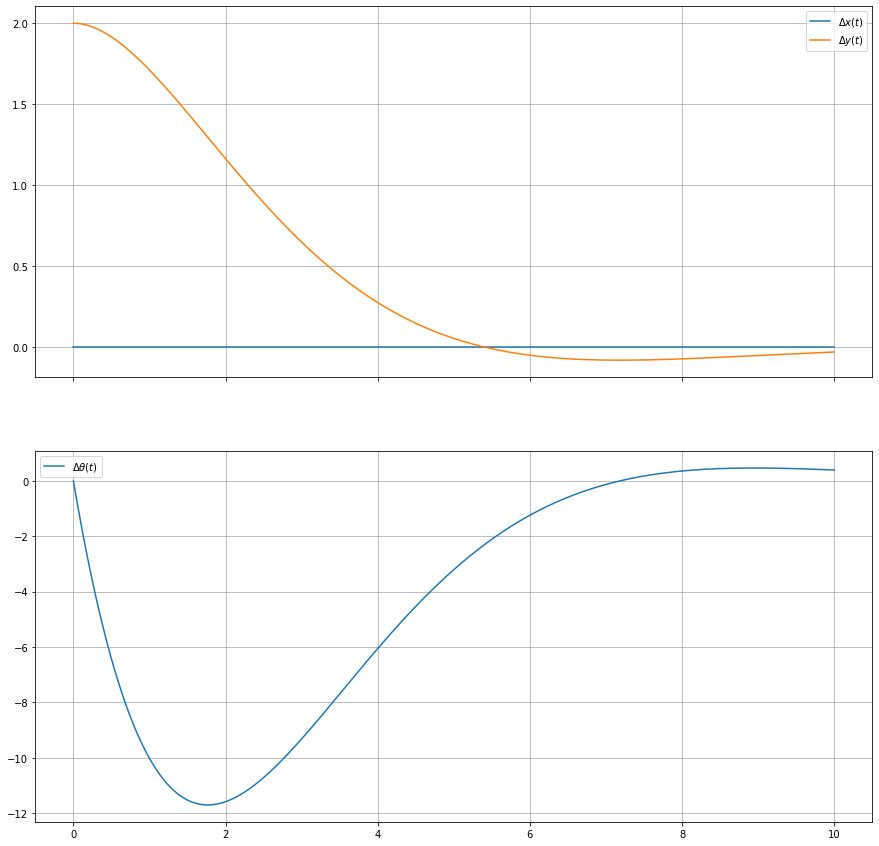

In [743]:
# with a large Q 

print(" Simulation for larger Q :")
Q_large=20*Q


Pi = linalg.solve_continuous_are(A, B, Q, R_matrix)
K = inv(R_matrix) @ B.T @ Pi


# plot graphs
tf = 10
r = solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)
#plots
t = linspace(0.0,tf, 1000)
x, y, theta = r["sol"](t)
fig1=figure(figsize=(15, 15))
ax1, ax2 = fig1.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$\Delta x(t)$")
ax1.plot(t, y, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta*180/pi, label=r"$\Delta\theta(t)$")
ax2.legend()





#### Simulation for larger R :

Simulation for larger R:


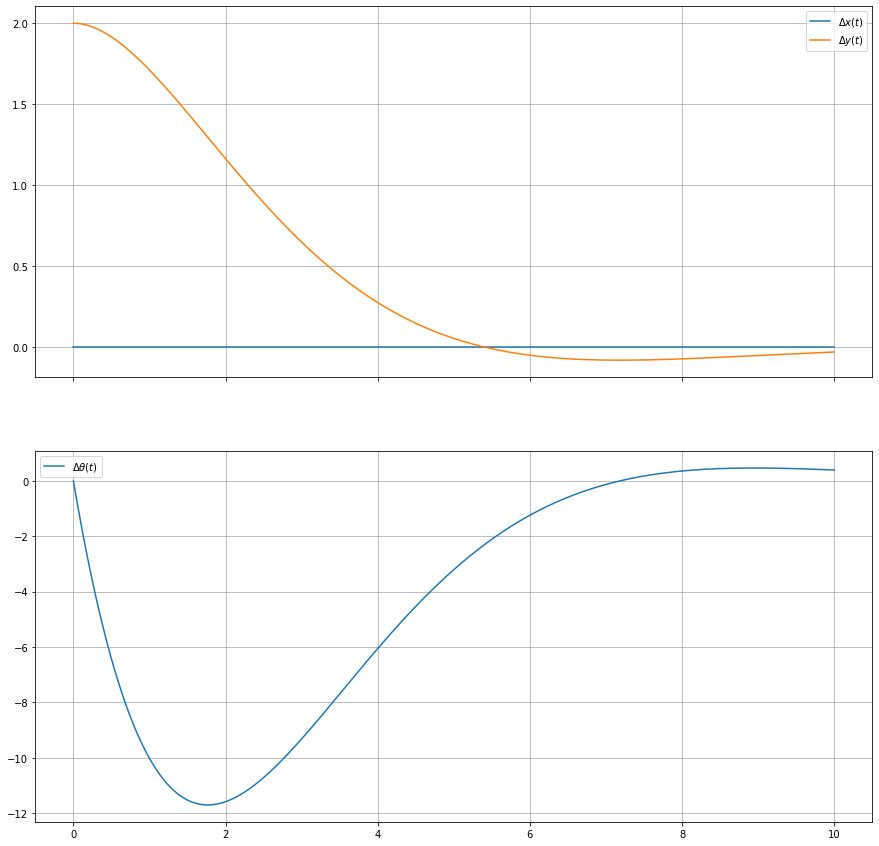

In [744]:

# with a large R
print("Simulation for larger R:")
R_large=20*R_matrix


Pi = linalg.solve_continuous_are(A, B, Q, R_matrix)
K = inv(R_matrix) @ B.T @ Pi


# Plot graphs
tf = 10
r = solve_ivp(fun=lin_fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)
#plots
t = linspace(0.0,tf, 1000)
x, y, theta = r["sol"](t)
fig2=figure(figsize=(15, 15))
ax1, ax2 = fig2.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$\Delta x(t)$")
ax1.plot(t, y, label="$\Delta y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta*180/pi, label=r"$\Delta\theta(t)$")
ax2.legend()

🧩 For a given strategy, write a function that returns the Euclidean norm of the state and the norm of the control effort. Compare on the same plots (one for the norm of the state and one for the control effort) the results you obtain using the three different controllers.

In [745]:
def norm_vals(i,r):
    return norm(r(i)), norm( omega(i, r(i)))

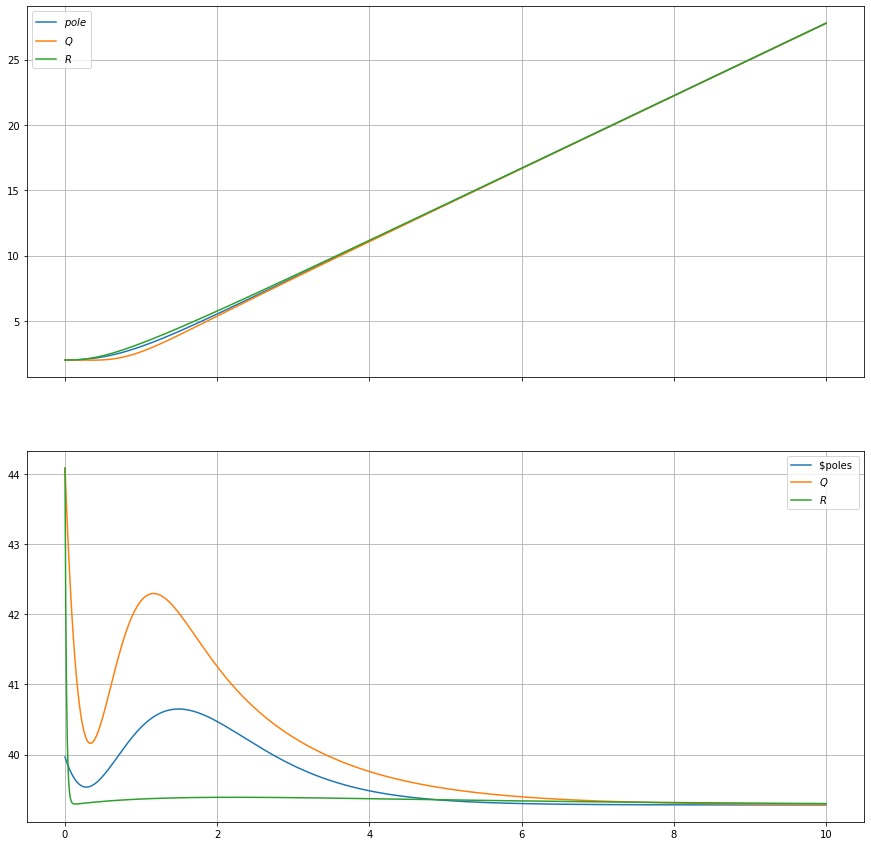

In [765]:


tf = 10
t = linspace(0.0,tf, 1000)

#pole placement 1
poles = [-1.2,-1.21,-1.22] # Strictly negative real part
K = place_poles(A,B,poles).gain_matrix
r = solve_ivp(fun=fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)
state_1 = [norm_vals(i,r["sol"])[0] for i in t]
control_effort_1=[norm_vals(i,r["sol"])[1] for i in t]

#optimal controller large Q 2
Q=np.eye(3)*100
R_matrix=np.eye(2)
Pi = linalg.solve_continuous_are(A, B, Q, R_matrix)
K_largeQ = inv(R_matrix) @ B.T @ Pi
K=K_largeQ
r = solve_ivp(fun=fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)
state_2 =[norm_vals(i,r["sol"])[0] for i in t]
control_effort_2=[norm_vals(i,r["sol"])[1] for i in t]

#optimal controller large R 2

Q=np.eye(3)
R_matrix=np.eye(2)*100
Pi = linalg.solve_continuous_are(A, B, Q, R_matrix)
K_largeR = inv(R_) @ B.T @ Pi

K=K_largeR
r = solve_ivp(fun=fun,t_span=[0,tf],y0=[0,2,0],dense_output=True, rtol=1e-6, atol=1e-12)
state_3 = [norm_vals(i,r["sol"])[0] for i in t]
control_effort_3=[norm_vals(i,r["sol"])[1] for i in t]

fig=figure(figsize=(15, 15))
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, state_1, label="$pole$")
ax1.plot(t, state_2, label="$Q$")
ax1.plot(t, state_3, label="$R$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, control_effort_1, label="$poles ")
ax2.plot(t, control_effort_2, label="$Q$")
ax2.plot(t, control_effort_3, label="$R$")
ax2.legend()

🧩 There is some wind (constant speed) that can disturb the behavior of the robot. How can you model the effect of this wind? What is the impact on the performance (you can choose the controller of your choice)?

🧩 What happen if the controller is subject to a delay $\delta$? Is there a value of $\delta$ for which the system becomes unstable? What would be the physical meaning of such a delay?

pass

🧩 What happen if the controller brutally stops at t=5s?

In [50]:
pass

🧩 What if the robot starts with a wrong orientation?

###  Nose Dynamics

🧩 Write the differential equation satisfied by the location $(x_n, y_n)$ of the robot nose. 

# Answer

L'objectif est de déterminer les équations du nez de robot on sait que :

Position initial :

$x_N = \frac{D}{2}cos(\theta_0) +x_0$

$y_N = \frac{D}{2}sin(\theta_0) +y_0$

Par projection du point N (nez de Robot), on a:


$x_N = \frac{D}{2}cos(\theta) +x$

$y_N = \frac{D}{2}sin(\theta) +y$

On dérive les coordonées du point N ($x_N, y_N$) et on obtient:

$\dot{x_N} = -\frac{D}{2}sin(\theta)\dot{\theta} + \dot{x}$

$\dot{y_N} = \frac{D}{2}cos(\theta)\dot{\theta} + \dot{y}$

🧩 Show any (smooth) reference evolution of the robot nose $(x_n^r(t), y_n^r(t))$ and any initial state of the robot consistent with the initial nose location, there is an admissible trajectory $(x(t), y(t), \theta(t))$ that corresponds to this reference. Hint: search the unique $\omega_l(t)$ and $\omega_r(t)$ -- as functions of $\dot{x}_n^r(t)$, $\dot{y}_n^r(t)$ and $\theta(t)$ -- that satisfies this property. 

## ANSWER
on a :

$$\dot{x_N} = -\frac{D}{2} sin(\theta). \dot{\theta} + \dot{x}$$

$$\dot{y_N} = \frac{D}{2} cos(\theta). \dot{\theta} + \dot{y}$$

Avec :

$$
\begin{array}{rcl}
\dot{x} &=& R  \frac{\omega_l + \omega_r}{2} \cos \theta \\
\dot{y} &=& R  \frac{\omega_l + \omega_r}{2} \sin \theta \\
\dot{\theta} &=& R  \frac{\omega_r - \omega_l}{D} \\
\end{array}
$$

On cherche à exprimer les vitesses angulaires $w_G$  et  $w_D$ et par développement de calcul et en considérant les condition de reference on trouve:

$$(1)$$
$$\dot{x_n^r} = -\frac{R}{2}sin(\theta)(w_r - w_l) + \frac{R}{2}(w_G + w_D)cos(\theta)$$

$$(2)$$
$$\dot{y_n^r} =  \frac{R}{2}cos(\theta)(w_r - w_l) + \frac{R}{2}(w_G + w_D)sin(\theta)  $$
 
en Calculant $(1)+(2)$ et $(1)-(2)$  :

$$\begin{pmatrix}
\dot{x_n^r} + \dot{y_n^r} \\
\dot{x_n^r} - \dot{y_n^r}
\end{pmatrix} = R.\begin{pmatrix}
Sin(\theta) & Cos(\theta) \\
Cos(\theta) & -Sin(\theta)  
\end{pmatrix} .  \begin{pmatrix}
\omega_l \\
\omega_r
\end{pmatrix}
$$

En calcule la matrice transope on trouve que :

$$\begin{pmatrix}
\omega_l \\
\omega_r
\end{pmatrix} = \frac{1}{R}.\begin{pmatrix}
Sin(\theta) & Cos(\theta) \\
Cos(\theta) & -Sin(\theta)  
\end{pmatrix} .  \begin{pmatrix}
\dot{x_n^r} + \dot{y_n^r} \\
\dot{x_n^r} - \dot{y_n^r}
\end{pmatrix}
$$


Finalement :

$$
\omega_l = \frac{1}{R} [(\dot{x_n^r} + \dot{y_n^r}) Sin(\theta) +  (\dot{x_n^r} - \dot{y_n^r}) Cos(\theta)] \\
\omega_r =  \frac{1}{R} [(\dot{x_n^r} + \dot{y_n^r}) Cos(\theta) -  (\dot{x_n^r} - \dot{y_n^r}) Sin(\theta)]
$$

🧩 Let $v>0$ be the value in m/s that corresponds to $10$ km/h and let $(x_n^r(t), y_n^r(t)) = (vt, 0)$.
Simulate the robot evolution with the choice for $\omega_l$ and $\omega_r$ of the previous question for different values of $X(0)$. In particular, investigate the case of à $\theta(0)$ close to $0$, then close to $\pi$. Is the system dynamics asymptotically stable in each case ?

# Answer

On a :
$$
\omega_l = \frac{1}{R} [(\dot{x_n^r} + \dot{y_n^r}) Sin(\theta) +  (\dot{x_n^r} - \dot{y_n^r}) Cos(\theta)] \\
\omega_r =  \frac{1}{R} [(\dot{x_n^r} + \dot{y_n^r}) Cos(\theta) -  (\dot{x_n^r} - \dot{y_n^r}) Sin(\theta)]
$$

et on a :

$$(x_n^r(t), y_n^r(t)) = (vt, 0)$$


En Remplacant dans les équations (1) :

$$
\omega_l = \frac{v}{R}[  Sin(\theta) +  Cos(\theta) ]\\
\omega_r =  \frac{v}{R} [  Cos(\theta) -  Sin(\theta) ]
$$



# Answer
On cherche à trouver l'expression de $\dot{\theta}$

On a  :

$$
\omega_l = \frac{v}{R}[  Sin(\theta) +  Cos(\theta) ]\\
\omega_r =  \frac{v}{R} [  Cos(\theta) -  Sin(\theta) ]
$$

Or on a :

$$
\dot{\theta} = R  \frac{\omega_r - \omega_l}{D} =  = -2\frac{v}{D}.sin(\theta)
$$


🧩 Consider three pillars (of radius 10 cm) whose centers are aligned and distant of 3 meters, say at the locations
$$
(1.5,0), (4.5, 0) \mbox{ and } (7.5,0).
$$
Compute a reference trajectory trajectory that would lead the robot nose from $(0,0)$ (with a robot pointing to the right) to $(9,0)$ with a slalom between the pillars. Of course, you don't want the robot frame to bump into the pillars ! Display this trajectory graphically. What happens when if the inputs $\omega_l(t)$ and $\omega_r(t)$ are applied but the robot is not initially at the expected position ?

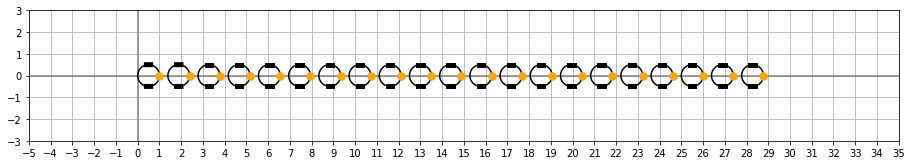

In [771]:
# D'apres les equations precidentes
# Theta close to 0
x0 = 0.0 ; y0 = 0.0 ; theta0 = 0.001
X_n=x0+ (D/2)*cos(theta0); Y_n = y0+(D/2)*sin(theta0)  
position_init = [X_n,  Y_n , theta0]

t_span=[0.0,10]    
def nose_equat(t, X):
    x, y, theta = X
    dx=v
    dy=0
    dtheta=-2*sin(theta)*(v/D)
    dX = array([dx, dy, dtheta])
    return dX

r=solve_ivp( nose_equat , t_span, position_init,  dense_output=True, max_step=0.01)

# display the trajectory of the robot

step = 0.5
t = arange(0,tf+step,step)
sol_t = r["sol"](t)
draw_arena(-5, 35, -3, 3)
for x, y, theta in sol_t.T:
    draw_robot(x, y, theta)


**on peut voir que la trajectoire du nez du robot est asymptotiquement stable au voisinage de 0**

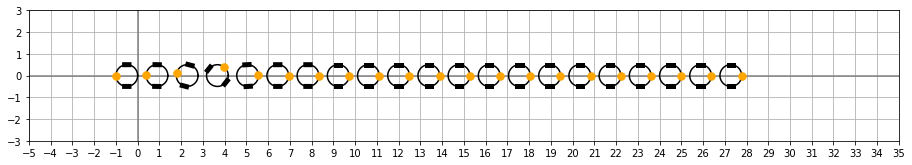

In [773]:
# theta close to 𝜋

x0 = 0.0 ; y0 = 0.0 ; theta0 = pi-0.001
X_n=x0+ (D/2)*cos(theta0); Y_n = y0+(D/2)*sin(theta0)  
position_init = [X_n,  Y_n , theta0]

t_span=[0.0,10]    
def nose_equat(t, X):
    x, y, theta = X
    dx=v
    dy=0
    dtheta=-2*sin(theta)*(v/D)
    dX = array([dx, dy, dtheta])
    return dX
r=solve_ivp( nose_equat , t_span, position_init,  dense_output=True, max_step=0.01)



# display the trajectory of the robot

step = 0.5
t = arange(0,tf+step,step)
sol_t = r["sol"](t)
draw_arena(-5, 35, -3, 3)
for x, y, theta in sol_t.T:
    draw_robot(x, y, theta)


**on peut voir que la trajectoire du nez du robot n'est pas asymptotiquement stable pour theta proche de 𝜋**